In [ ]:
import tensorflow as tf
import keras
from keras import layers
import pandas as pd
import os
import seaborn as sns

import matplotlib.pyplot as plt
import kagglehub
import numpy as np
import random
from wordcloud import WordCloud

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
path = kagglehub.dataset_download("mariumfaheem666/spam-sms-classification-using-nlp")
file = os.listdir(path)
filepath = f"{path}/{file[0]}"
data = pd.read_csv(filepath)

print(data.head())
print(data.info())

  Class                                            Message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Class    5574 non-null   object
 1   Message  5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None


In [ ]:
label_encoder = LabelEncoder()
data['Class'] = label_encoder.fit_transform(data['Class'])  # 'spam' as 1, 'ham' as 0

# Convert all messages to lowercase for consistency
data['Message'] = data['Message'].str.lower()

x_train, x_test, y_train, y_test = train_test_split(data['Message'], data['Class'], test_size=0.2, random_state=42, stratify=data['Class'])

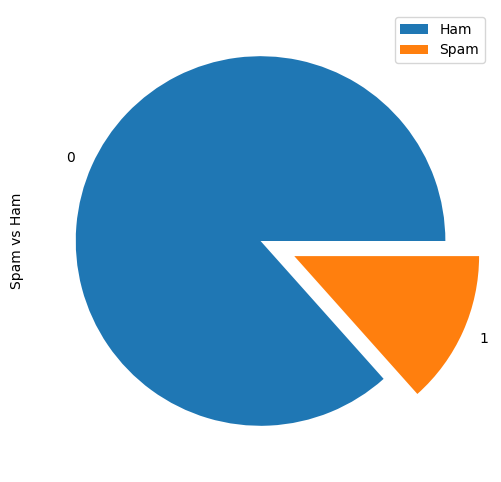

In [ ]:
data["Class"].value_counts().plot(kind = 'pie', explode = [0, 0.2], figsize = (6, 6))
plt.ylabel("Spam vs Ham")
plt.legend(["Ham", "Spam"])
plt.show()

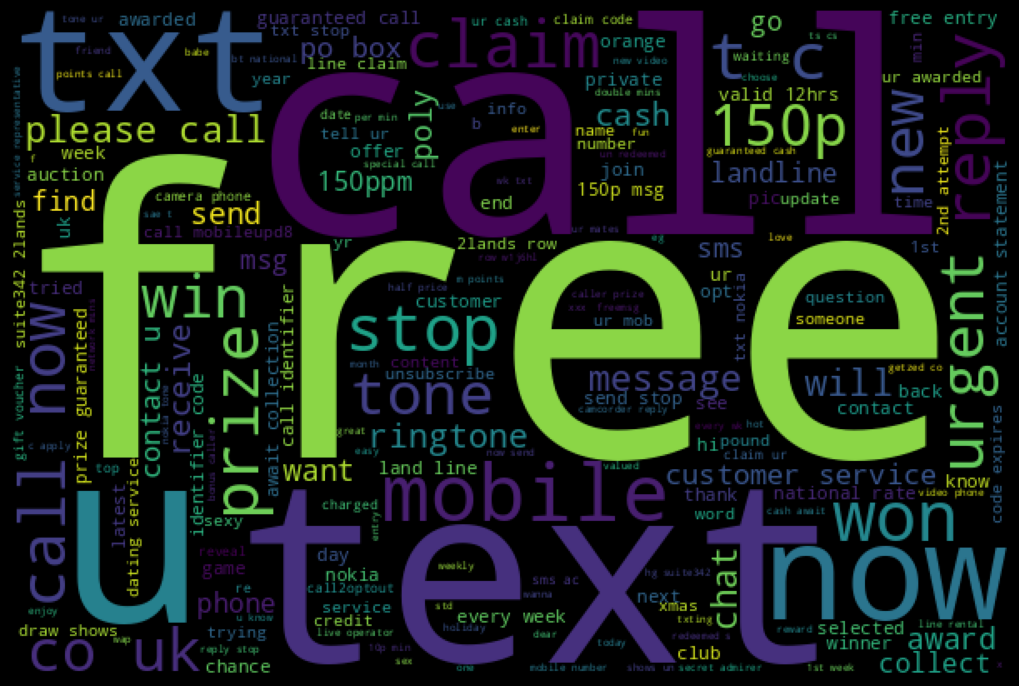

In [ ]:
#Spam Word cloud
spam_messages = data[data['Class'] == 1]  # Assuming 'spam' is encoded as 1
spam_words = " ".join(spam_messages['Message'])
spam_wordcloud = WordCloud(width=600, height=400).generate(spam_words)
plt.figure( figsize=(10,8), facecolor='k')
plt.imshow(spam_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

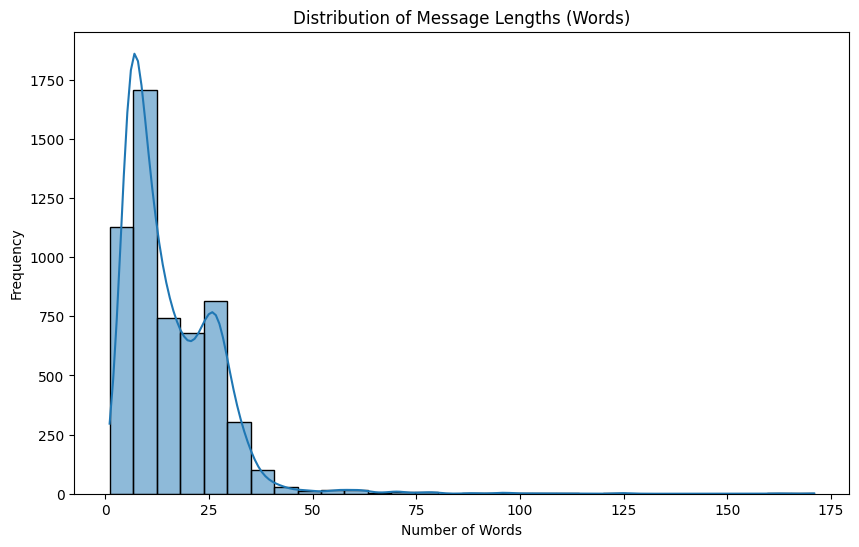

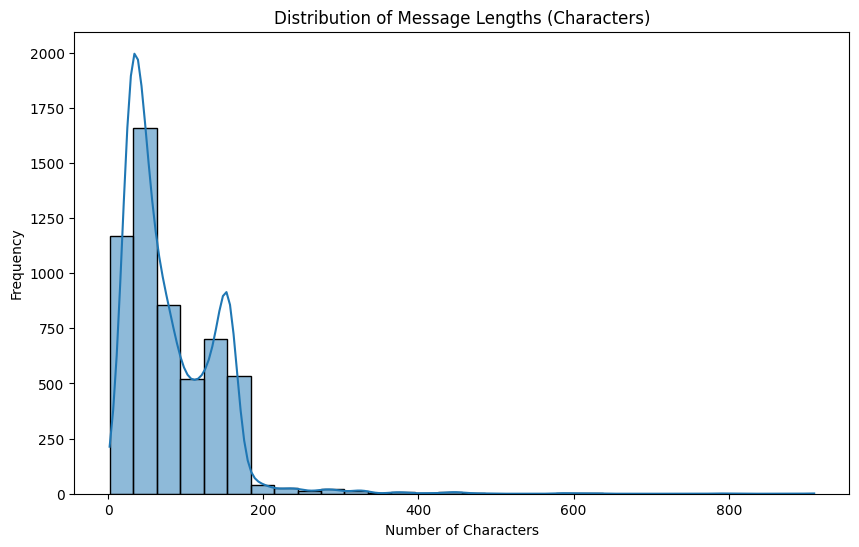

In [ ]:
# Calculate message length in terms of number of words
data['message_length_words'] = data['Message'].apply(lambda x: len(x.split()))

# Calculate message length in terms of number of characters
data['message_length_chars'] = data['Message'].apply(len)

# Plot histogram for message lengths by words
plt.figure(figsize=(10, 6))
sns.histplot(data['message_length_words'], bins=30, kde=True)
plt.title("Distribution of Message Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

# Plot histogram for message lengths by characters
plt.figure(figsize=(10, 6))
sns.histplot(data['message_length_chars'], bins=30, kde=True)
plt.title("Distribution of Message Lengths (Characters)")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

When we prepare text for an RNN, we need each sequence (message) to have the same length because the model expects fixed-length input. To make them all the same length, we add padding. We add zeros to the end of shorter messages to match the length of the specified max_length.

In [ ]:
vocab_size = 1000
max_length = 50   #based on message length distribution

# Define the TextVectorization layer
text_vec_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=max_length
)

text_vec_layer.adapt(x_train)

# Check the vectorized and padded output for a few samples
sample_sequences = text_vec_layer(x_train[145:150])

for i, seq in enumerate(sample_sequences.numpy()):
    print(f"Sample {i + 1}: {seq}")

Sample 1: [62 92  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
Sample 2: [ 14 291   2  31  19   5   1   1 419  16  23   1  38   1 231 304 913 736
 302 299   1   1   1   1   1  10   5 849 517  16   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Sample 3: [135 473   7 258  58   1 208  27 337   3 258  24 341   1  22   1 607  11
 429  30  79   3 146 123  62  87   1  12 145   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Sample 4: [ 24 269 682   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
Sample 5: [  1 439  44 270  35  39 181 106  42  46 238 212   9  64 105 408   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0  

**Interesting Fact:** We added this step because training the GRU model initially caused an error. cuDNN, the GPU-optimized backend for RNNs, only supports right-padded sequences. When left-padded sequences are present, as we found in our data, cuDNN needs to be disabled. Disabling cuDNN allows the GRU to handle left-padded inputs but may slightly slow down training.

In [ ]:
x_train_vectorized = text_vec_layer(x_train)
x_train_vectorized_np = x_train_vectorized.numpy()
fully_padded_items = np.all(x_train_vectorized_np == 0, axis=1)
fully_padded_indices = np.where(fully_padded_items)[0]

print(f"Number of fully padded items in training set: {len(fully_padded_indices)}\n")

for index in fully_padded_indices:
    original_message = x_train[index]
    vectorized_message = x_train_vectorized_np[index]
    print(f"Original message at index {index}: {original_message}")
    print(f"Vectorized message at index {index}: {vectorized_message}\n")

Number of fully padded items in training set: 1

Original message at index 1844: super da:)good replacement for murali
Vectorized message at index 1844: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]



The padding (the zeros) is just "filler" and doesn’t contain any real information about the message. If the model pays attention to these zeros as if they were real words, it could confuse the model or make learning harder. When mask_zero is set to True in the Embedding layer, the model ignore any zeros in the input sequence. So, when the RNN processes the sequence, it skips over the padding zeros and only focuses on the actual words in the message.

# RNN

In [ ]:
rnnModel = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128),
    tf.keras.layers.SimpleRNN(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_precision',
    patience=5,
    restore_best_weights=True
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

rnnModel.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['precision'])
rnnModel.fit(x_train, y_train, batch_size=128, epochs=30, validation_data=(x_test, y_test), callbacks=[early_stopping_cb])

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.4617 - precision: 0.0000e+00 - val_loss: 0.3718 - val_precision: 0.0000e+00
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.2752 - precision: 0.5843 - val_loss: 0.1540 - val_precision: 0.8414
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.1351 - precision: 0.8922 - val_loss: 0.1351 - val_precision: 0.9185
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.1085 - precision: 0.9508 - val_loss: 0.1251 - val_precision: 0.9913
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.0860 - precision: 0.9797 - val_loss: 0.1052 - val_precision: 0.9214
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0664 - precision: 0.9726 - val_loss: 0.1194 - val_precision: 0.8889
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0603 - precision: 0.9908 - val_loss: 0.1205 - val_precision: 0.8776
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0563 - precision: 0.9925 - v

Confusion Matrix RNN

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


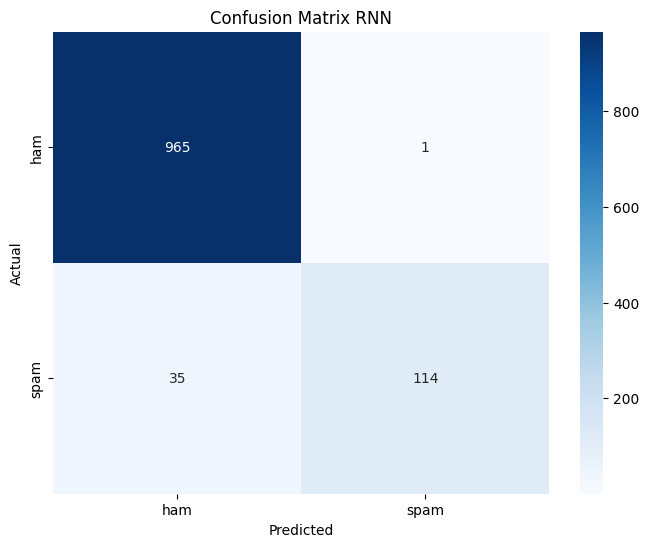

In [ ]:
# Get predictions
predictions = (rnnModel.predict(x_test) > 0.5).astype("int32").flatten()

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix RNN')
plt.show()


# GRU

In [ ]:
batch_size = 128
epochs = 40
tf.random.set_seed(42)

gruModel = tf.keras.Sequential([
    text_vec_layer,
    layers.Embedding(input_dim = vocab_size, output_dim = 128, mask_zero=True),
    layers.GRU(128, use_cudnn=False),
    layers.Dense(1, activation="sigmoid")
])

optimizer = keras.optimizers.Adam(learning_rate=0.0005)
gruModel.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['precision'])

# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_precision', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

history = gruModel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test, y_test), callbacks=callbacks)


Epoch 1/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.5968 - precision: 0.0681 - val_loss: 0.3540 - val_precision: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.2757 - precision: 0.8439 - val_loss: 0.1224 - val_precision: 0.8269 - learning_rate: 5.0000e-04
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.1134 - precision: 0.8687 - val_loss: 0.0801 - val_precision: 0.9013 - learning_rate: 5.0000e-04
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0651 - precision: 0.9347 - val_loss: 0.0662 - val_precision: 0.9247 - learning_rate: 5.0000e-04
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0425 - precision: 0.9747 - val_loss: 0.0649 - val_precision: 0.9324 - learning_rate: 5.0000e-04
Epoch 6/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0306 - precision: 0.9841 - val_loss: 0.0639 - val_precision: 0.9388 - learning_rate: 5.0000e-04
Epoch 7/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - l

Confusion Matrix GRU (trainable embedings)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


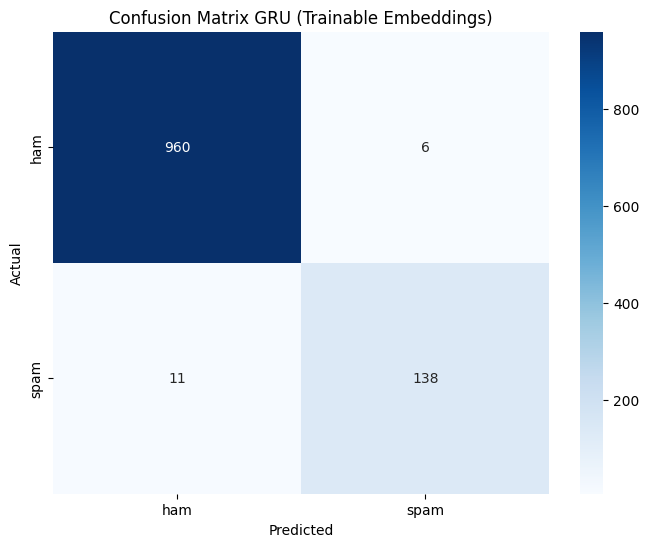

In [ ]:
# Get predictions
predictions = (gruModel.predict(x_test) > 0.5).astype("int32").flatten()

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix GRU (Trainable Embeddings)')
plt.show()

###One-hot encoding vs trainable embeddings

As can be seen above trainable embeddings performed significantly better than one-hot encoding in this case. One-hot encoding treats each word as isolated, which means the model can't capture context. In contrast, trainable embeddings learn contextual word representations and the model recognizes patterns between related words (for example "offer" and "discount").

The model with embeddings achieved high precision, while the one-hot encoded model shown below struggled and defaulted to labeling all inputs as “ham.” Lowering the  threshold (from 0.5 to 0.3) improved its performance, but embeddings remain more effective for accurate spam detection.

In [ ]:
# One-hot encoding

# Integer encode the data
text_vec_layer = layers.TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=max_length,
    output_mode="int"
)

text_vec_layer.adapt(x_train)

# Transform the text data to integer indices
x_train_one_hot = text_vec_layer(x_train)
x_test_one_hot = text_vec_layer(x_test)


gruModel_one_hot = tf.keras.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True, input_length=max_length),  # Using 128 dimensions instead of vocab_size
    layers.GRU(128, use_cudnn=False),
    layers.Dense(1, activation="sigmoid")
])


# Compile the model
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
gruModel_one_hot.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['precision'])

# Train the model with correctly matched validation data
history = gruModel_one_hot.fit(
    x_train_one_hot, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test_one_hot, y_test),
    callbacks=callbacks
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - loss: 0.6007 - precision: 0.0894 - val_loss: 0.3553 - val_precision: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 2/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.2760 - precision: 0.8438 - val_loss: 0.1223 - val_precision: 0.8247 - learning_rate: 5.0000e-04
Epoch 3/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1135 - precision: 0.8767 - val_loss: 0.0821 - val_precision: 0.8889 - learning_rate: 5.0000e-04
Epoch 4/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0657 - precision: 0.9400 - val_loss: 0.0662 - val_precision: 0.9252 - learning_rate: 5.0000e-04
Epoch 5/40
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0424 - precision: 0.9771 - val_loss: 0.0646 - val_precision: 0.9262 - learning_rate: 5.0000e-04


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


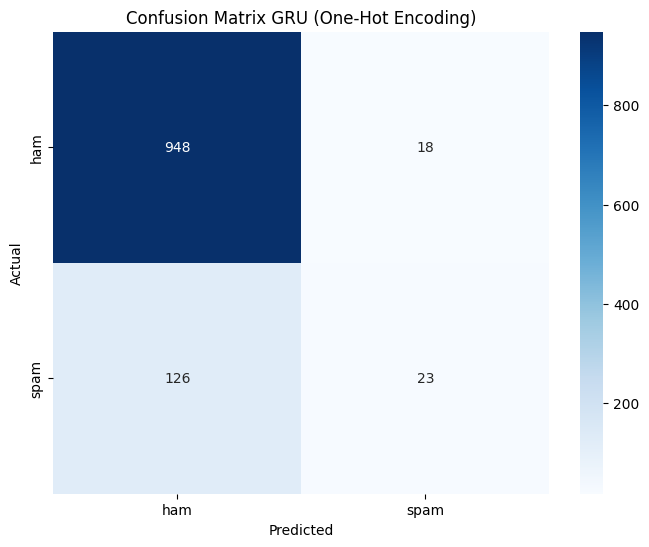

In [ ]:
# Get predictions from the model
predictions = (gruModel_one_hot.predict(x_test_one_hot) > 0.3).astype("int32").flatten()

cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix GRU (One-Hot Encoding)')
plt.show()


###Testing

In [ ]:
test_messages = [
    "Congratulations! You've won a $1000 gift card. Click here to claim your prize now.",
    "Limited time offer! Get 50% off all items. Hurry, the offer expires soon. Reply STOP to unsubscribe.",
    "Hey, are we still on for lunch tomorrow? Let me know what time works for you.",
    "Please review the report I sent last night. I need your feedback by Friday.",
    "Don't miss out on this amazing opportunity. Act now for more details!"
]

test_messages = [message.lower() for message in test_messages]
df = pd.DataFrame({"Message": test_messages})
test_messages_array = df["Message"].values.reshape(-1, 1)

rnn_predictions = rnnModel.predict(test_messages_array)
gru_predictions = gruModel.predict(test_messages_array)

# Print out predictions
for i, message in enumerate(test_messages):
    print(f"Message {i + 1}: {message}")
    print(f"RNN Prediction: {'Spam' if rnn_predictions[i] > 0.5 else 'Ham'} ({rnn_predictions[i][0]:.2f})")
    print(f"GRU Prediction: {'Spam' if gru_predictions[i] > 0.5 else 'Ham'} ({gru_predictions[i][0]:.2f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Message 1: congratulations! you've won a $1000 gift card. click here to claim your prize now.
RNN Prediction: Spam (0.53)
GRU Prediction: Spam (1.00)

Message 2: limited time offer! get 50% off all items. hurry, the offer expires soon. reply stop to unsubscribe.
RNN Prediction: Ham (0.17)
GRU Prediction: Spam (0.99)

Message 3: hey, are we still on for lunch tomorrow? let me know what time works for you.
RNN Prediction: Ham (0.03)
GRU Prediction: Ham (0.00)

Message 4: please review the report i sent last night. i need your feedback by friday.
RNN Prediction: Ham (0.06)
GRU Prediction: Ham (0.00)

Message 5: don't miss out on this amazing opportunity. act now for more details!
RNN Prediction: Ham (0.04)
GRU Prediction: Ham (0.03)



## RNN va GRU


Above can be seen that the GRU model outperformed the traditional RNN. This is becuase RNN faces the issue of the vanishing gradient, making it difficult to retain information over long inputs. This is particularly problematic in our case of spam detection, where identifying spammy content relies on detecting patterns or keywords that may appear at different positions within a message.

The GRU model, by contrast, has a "reset" and "update" gate, allowing it to selectively remember or forget information. As a result it can better capture relevant context and the patterns associated with spam.